# AlphaShoe

SD210 Challenge

 - [scoreboard and submissions](http://datachallenge.enst.fr/)
 - [starting kit](http://nbviewer.jupyter.org/urls/dl.dropboxusercontent.com/s/hmrfrurkyoohi3v/moussab%20djerrab%20-%20DataChallenge_ShoeReturns.ipynb)
 - [training data](https://www.dropbox.com/sh/uo4oudw43j45mp3/AACA0UqkitNKSWdE_7fs2Wbla?dl=0)
 - [dictionnary](https://www.dropbox.com/sh/uo4oudw43j45mp3/AACA0UqkitNKSWdE_7fs2Wbla?dl=0&preview=dictionnary.xlsx)

### Importations

In [1]:
# coding: utf-8

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
import datetime
import pandas as pd
import numpy as np
import time

%matplotlib inline

def log(text, t_start=None):
    if t_start is None:
        print(text)
    else:
        elapsed_time = round(time.time() - t_start, 2)
        print(text + "\t(" + str(elapsed_time) + "s)")


### Loading files

In [2]:
t = time.time()
customers = pd.read_csv("data/customers.csv")
products = pd.read_csv("data/products.csv")
x_train = pd.read_csv("data/X_train.csv")
y_train = pd.read_csv("data/y_train.csv")
x_test = pd.read_csv("data/X_test.csv")
y_test = pd.read_csv("data/y_test.csv")
log("files loaded", t)

files loaded	(8.48s)


### Data cleaning

In [113]:
# SizeAdviceDescription
SizeAdviceDescriptionCleaner = {}
SizeAdviceDescriptionCleaner['nan'] = 0
SizeAdviceDescriptionCleaner['Ce mod\xc3\x83\xc2\xa8le chausse normalement'] = 0
SizeAdviceDescriptionCleaner['Mod\xc3\x83\xc2\xa8le confortable, convient aux pieds larges'] = -.5
SizeAdviceDescriptionCleaner['Mod\xc3\x83\xc2\xa8le \xc3\x83\xc2\xa9troit, convient aux pieds fins'] = .5
SizeAdviceDescriptionCleaner['Prenez votre pointure habituelle'] = 0
SizeAdviceDescriptionCleaner['Chaussant particuli\xc3\x83\xc2\xa8rement g\xc3\x83\xc2\xa9n\xc3\x83\xc2\xa9reux. Nous vous conseillons de choisir deux tailles en dessous de votre pointure habituelle.'] = -2
SizeAdviceDescriptionCleaner['Chaussant petit. Si vous \xc3\x83\xc2\xaates habituellement entre deux pointures, nous vous conseillons de choisir une demi taille au-dessus de votre pointure habituelle.'] = .5
SizeAdviceDescriptionCleaner['Prenez une taille au-dessus de sa pointure !'] = 1
SizeAdviceDescriptionCleaner['Prenez une taille au-dessus de votre pointure habituelle'] = 1
SizeAdviceDescriptionCleaner['Prenez une taille en dessous de sa pointure !'] = -1
SizeAdviceDescriptionCleaner['Prenez une taille en dessous de votre pointure habituelle'] = -1

# datetime format:
# YYYY-MM-DD HH:mm:SS

# BirthDate
def age(birthdate):
    if type(birthdate) == type(" "):
        return 2016 - int(birthdate[:4])
    return None

def week_of_the_year(date):
    if type(date) == type(" "):
        year = int(date[:4])
        month = int(date[5:7])
        day = int(date[8:10])
        return datetime.date(year, month, day).isocalendar()[1]
    return None

def hour(date):
    if type(date) == type(" "):
        return int(date[11:13])
    return None

# OrderCreationDate and SeasonLabel
def order_season(orderdate):
    month = int(orderdate[5:7])
    if month >= 4 and month <= 9:
        return "Printemps/Et\xc3\x83\xc2\xa9"
    return "Automne/Hiver"

def build_df(x):
    """Builds a pandas DataFrame with clean columns from a read CSV"""
    
    t = time.time()
    m = None
    
    # join
    m = pd.merge(x, products, how='left', on='VariantId', suffixes=('_pr', ''))
    m = pd.merge(m, customers, how='left', on='CustomerId', suffixes=('_cs', ''))
    
    # converting UnitPMPEUR
    m.UnitPMPEUR = m["UnitPMPEUR"].map(lambda row: float(row.replace(',', '.')))
    
    # building news columns
    m["MatchGender"] = m["Gender"] == m["GenderLabel"]
    m["MatchSeason"] = m["SeasonLabel_pr"] == m["SeasonLabel"]
    m["OrderSeason"] = m["OrderCreationDate"].map(order_season)
    m["MatchOrderSeason"] = m["OrderSeason"] == m["SeasonLabel"]
    m["OrderHour"] = m["OrderCreationDate"].map(hour)
    m["FirstOrderDate"] = m["FirstOrderDate"].map(week_of_the_year)
    
    # cleaning
    m["SizeAdviceDescription"] = m["SizeAdviceDescription"].map(SizeAdviceDescriptionCleaner)
    m["BirthDate"] = m["BirthDate"].map(age)
        
    # removing useless columns
    blacklist = ['VariantId', 'CustomerId', 'OrderNumber', 'LineItem',
                 'ProductColorId', 'OrderShipDate',
                 'ProductId', 'BillingPostalCode', 'SupplierColor',
                 'OrderStatusLabel',
                 'OrderCreationDate', 'SubtypeLabel', 'ProductType',
                ]
    whitelist = None
    if blacklist is not None:
        m = m.drop(blacklist, axis=1)
    if whitelist is not None:
        for col in m.columns:
            if col not in whitelist:
                m = m.drop([col], axis=1)

    print "dataframe shape:", m.shape
    log("dataframe built", t)
    return m

In [112]:
customers.columns

Index([u'CustomerId', u'CountryISOCode', u'BirthDate', u'Gender',
       u'FirstOrderDate'],
      dtype='object')

### Statistics

In [4]:
def returns_frequency(x, y, col, step):
    """Returns the returns frequencies for each value of a column"""
    
    counter = 0
    
    # counting occurences of each column value
    occurrences = {}
    for i, o in x.loc[::step].iterrows():
        counter += 1
        if str(o[col]) not in occurrences.keys():
            occurrences[str(o[col])] = [0., 0.]
        if y.loc[i, ["ReturnQuantityBin"]][0] == 0.0:
            occurrences[str(o[col])][0] += 1.
        else:
            occurrences[str(o[col])][1] += 1.
    
    # computing the returns frequency, stored in `recap`
    recap, values = [], []
    for val, (zeros, ones) in occurrences.items():
        values.append(((ones / (zeros + ones))))
        recap.append((val, values[-1]))
    recap.sort(key=lambda row: row[0])
    
    # computing variance and relative variance
    var = np.var(values)
    rel = var / len(values)
    
    return recap, var, rel, counter


def column_stats(x, y, col, step, verbose):
    """Computes the statistics for one column"""
    
    print "\n----- " + col + " -----"
    recap, var, rel, counter = returns_frequency(x, y, col, step)
    
    if verbose:
        for (val, freq) in recap:
            print val, "\t", freq, "returns"

    print "variance:", round(var, 5), "\tvalues count:", len(recap)
    return recap, var, rel, counter


def compute_statistics(x, y, blacklist=[], whitelist=[], step=100, verbose=False):
    ignored = []
    labels_g, labels_n = [], []
    scattering_g, scattering_n = [], []      # variances
    r_scattering_g, r_scattering_n = [], []  # variance divided by the number of differents values
    
    counter_cols = 0
    counter_rows = 0
    
    for col in x.columns:
        if col not in blacklist and x[col].dtype in ["object", "bool"]:
            counter_cols += 1
            labels_g.append(col)
            recap, var, rel, counter_rows = column_stats(x, y, col, step, verbose)
            scattering_g.append(var)
            r_scattering_g.append(rel)
        elif col not in blacklist and x[col].dtype in ["float64", "int64"]:
            counter_cols += 1
            labels_n.append(col)
            recap, var, rel, counter_rows = column_stats(x, y, col, step, verbose)
            scattering_n.append(var)
            r_scattering_n.append(rel)
            if col in whitelist:
                plot_dots([float(v[0]) for v in recap], [v[1] for v in recap], col)
        else:
            ignored.append(col)
    
    print "\n\nanalyzed", counter_cols, "columns and", counter_rows, "rows"
    print "\nignored columns:", ignored
    plot_barchart(labels_g, scattering_g, r_scattering_g, "general columns")
    plot_barchart(labels_g, scattering_g, r_scattering_g, "numerical columns")
    

def plot_barchart(labels, values_l, values_r, title):
    fig, ax = plt.subplots(figsize=(16, 10))
    ind = np.arange(len(values_l))
    width = .35
    ax.bar(ind - width/2, values_l, width)
    ax.bar(ind + width/2, values_r, width)
    ax.set_xticks(ind)
    ax.set_xticklabels(labels)
    plt.xticks(rotation=70)
    plt.title(title)
    plt.show()
    

def plot_dots(xs, ys, xlabel):
    plt.figure(figsize=(8, 5))
    plt.xlabel(xlabel)
    plt.ylabel("returns frequency")
    plt.plot(xs, ys, 'o')
    plt.show()

In [5]:
df_stats = build_df(x_train)

dataframe shape: (1067290, 34)
dataframe built	(4.56s)



----- OrderTypelabel -----
variance: 0.00017 	values count: 2

----- SeasonLabel_pr -----
variance: 7e-05 	values count: 2

----- PayementModeLabel -----
variance: 0.00472 	values count: 10

----- CustomerTypeLabel -----
variance: 0.00022 	values count: 2

----- IsoCode -----
variance: 0.04536 	values count: 20

----- DeviceTypeLabel -----
variance: 0.00124 	values count: 4

----- PricingTypeLabel -----
variance: 0.00072 	values count: 5

----- TotalLineItems -----
variance: 0.13073 	values count: 26


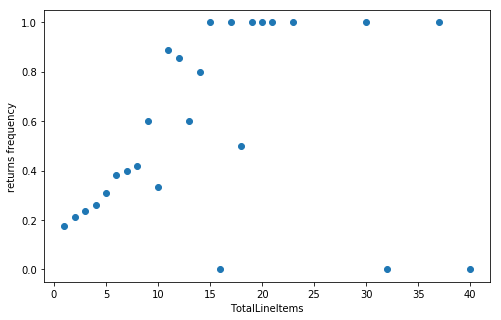


----- Quantity -----
variance: 0.01033 	values count: 4


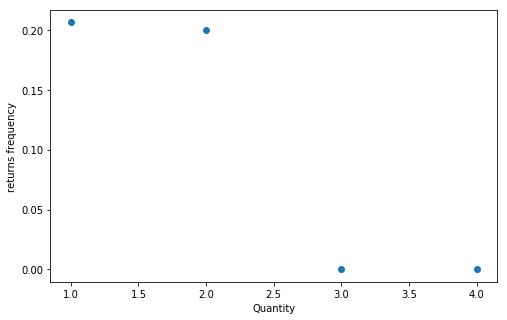


----- UnitPMPEUR -----
variance: 0.13264 	values count: 5066


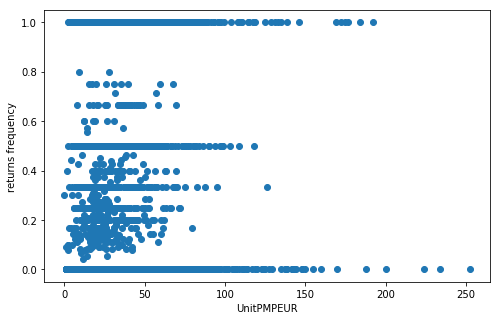


----- OrderNumCustomer -----
variance: 0.12625 	values count: 67


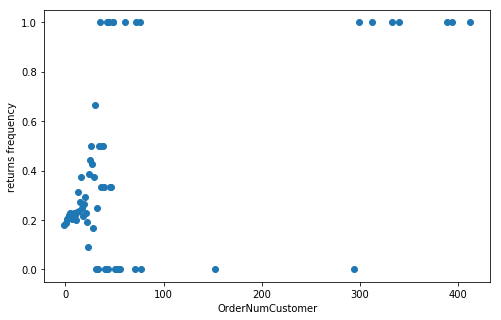


----- IsOnSale -----
variance: 0.00176 	values count: 3


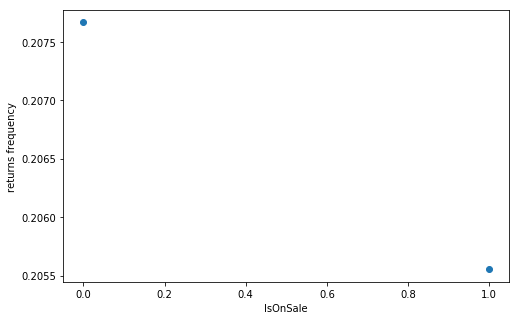


----- GenderLabel -----
variance: 0.00338 	values count: 6

----- MarketTargetLabel -----
variance: 0.00735 	values count: 14

----- SeasonLabel -----
variance: 0.00025 	values count: 3

----- SeasonalityLabel -----
variance: 0.00057 	values count: 4

----- UniverseLabel -----
variance: 0.00268 	values count: 9

----- TypeBrand -----
variance: 0.00581 	values count: 4

----- CalfTurn -----
variance: 0.08768 	values count: 20


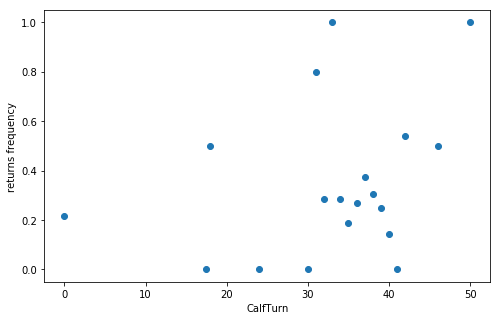


----- UpperHeight -----
variance: 0.05583 	values count: 49


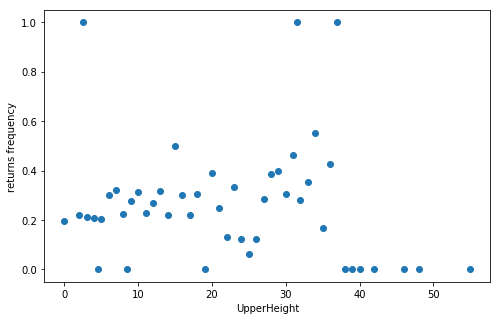


----- HeelHeight -----
variance: 0.01392 	values count: 18


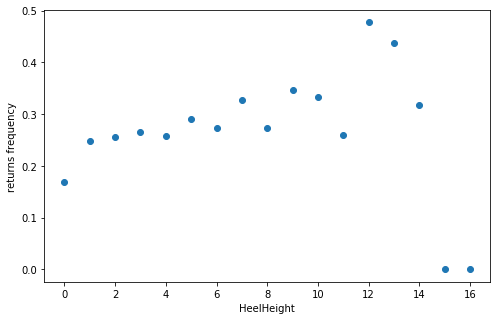


----- PurchasePriceHT -----
variance: 0.11134 	values count: 1446


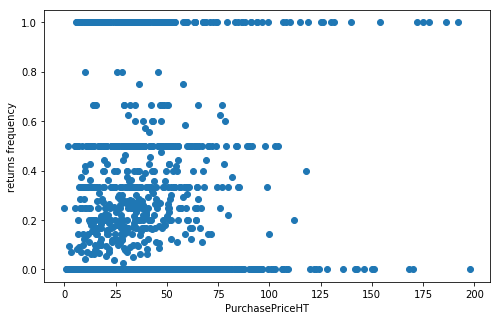


----- IsNewCollection -----
variance: 0.00217 	values count: 3


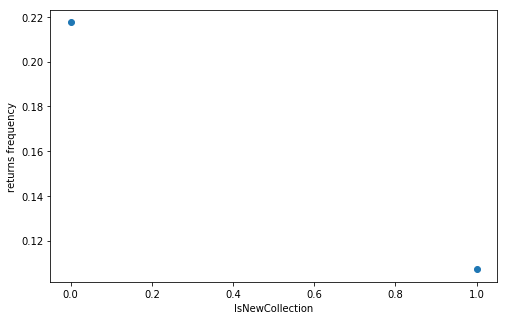


----- UpperMaterialLabel -----
variance: 0.00883 	values count: 9

----- LiningMaterialLabel -----
variance: 0.07434 	values count: 11

----- OutSoleMaterialLabel -----
variance: 0.01128 	values count: 8

----- RemovableSole -----
variance: 0.00039 	values count: 3

----- SizeAdviceDescription -----
variance: 0.0099 	values count: 7


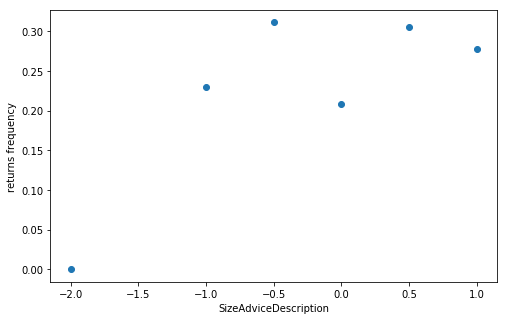


----- CountryISOCode -----
variance: 0.05302 	values count: 19

----- BirthDate -----
variance: 0.03355 	values count: 87


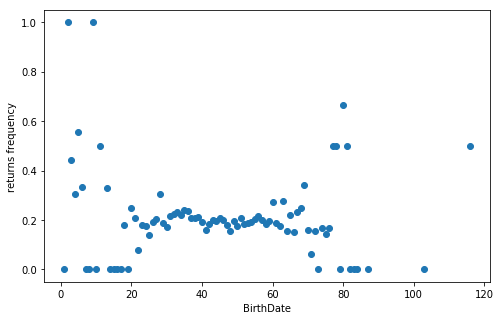


----- Gender -----
variance: 0.00061 	values count: 3

----- MatchGender -----
variance: 0.00048 	values count: 2

----- MatchSeason -----
variance: 0.00032 	values count: 2

----- MatchOrderSeason -----
variance: 0.00017 	values count: 2


analyzed 34 columns and 10673 rows

ignored columns: []


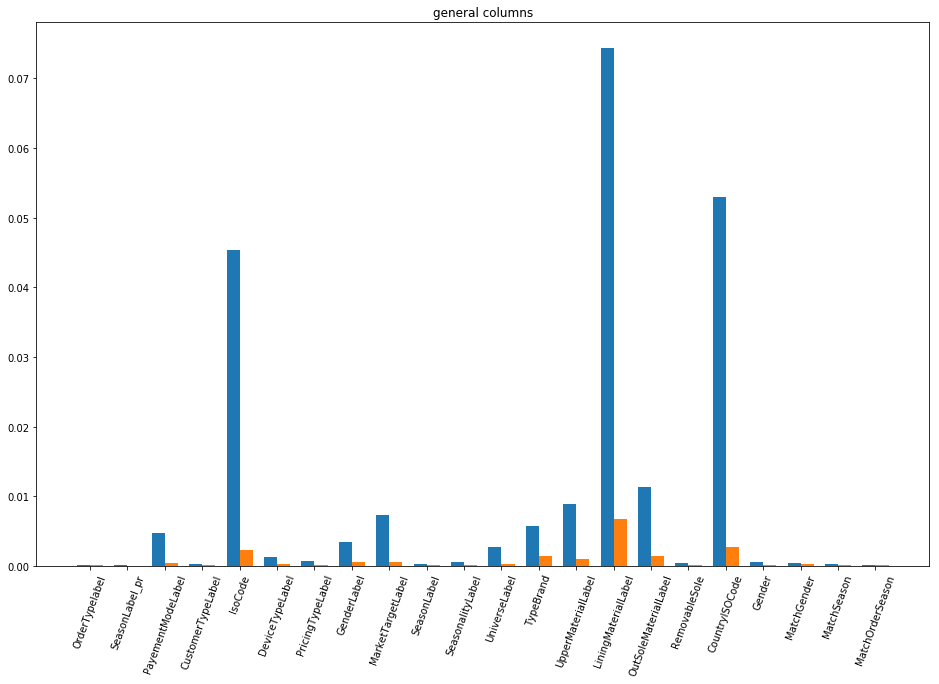

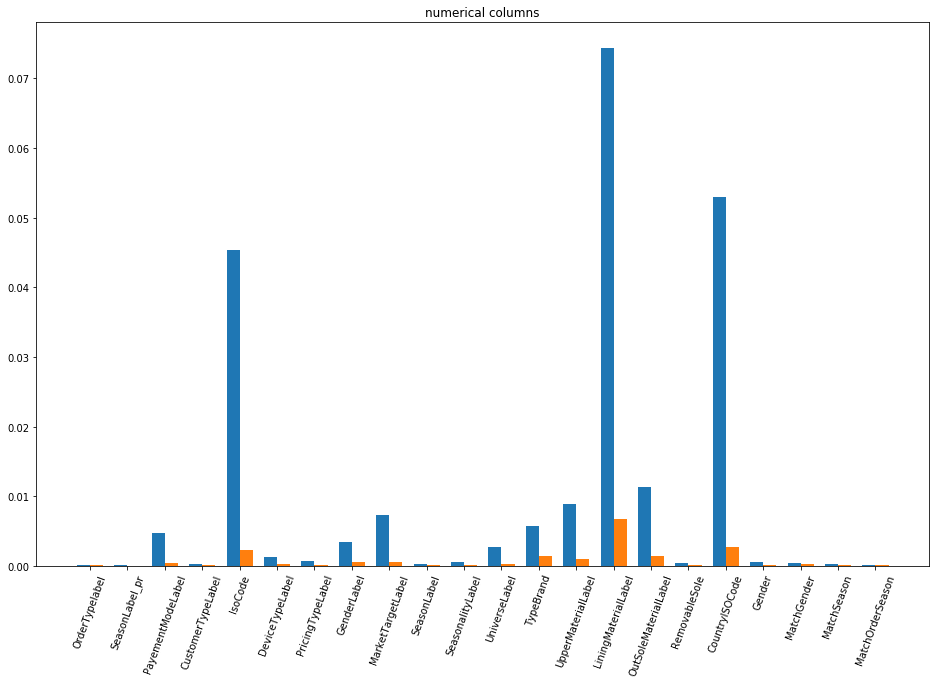

In [6]:
compute_statistics(df_stats, y_train, blacklist=[], whitelist=df_stats.columns, step=100)

In [ ]:
def prune(x, columns, variability, threshold):
    to_remove = []
    for i, col in enumerate(columns):
        if variability[i] < threshold:
            to_remove.append(col)
    return x.drop(to_remove, axis=1)

df_train_pruned = prune(df_train, labels, variability, 0.001)

### Classification

In [4]:
def mask(m):
    columns2bin = [col for col in m.columns if m[col].dtype == 'object']
    other_cols = m.drop(columns2bin, axis=1)
    new_cols = pd.get_dummies(m.loc[:, columns2bin])
    res = pd.concat([other_cols, new_cols], axis=1)
    res = res.fillna(0)
    print "new shape:", res.shape
    return res

def compute(name, clf, x1, x2, slc=100000):
    print "\n-----", name, "-----"
    clf.fit(x1.iloc[:slc], y_train.ReturnQuantityBin[:slc])
    
    predict_train = clf.predict_proba(x1.iloc[:slc])
    score_train = roc_auc_score(y_train.ReturnQuantityBin[:slc], predict_train[:, 1])
    print "train score:", score_train
    
    predict_test = clf.predict_proba(x1.iloc[slc:2 * slc])
    score_test = roc_auc_score(y_train.ReturnQuantityBin[slc:2 * slc], predict_test[:, 1])
    print "test score:", score_test
    return score_train, score_test

def compute_all(x1, x2, slc=100000):
    """Tries different classifiers and returns the best one (best test score)"""
    t = time.time()
    best_index, best_score = None, None
    
    print "train shape:\t", x1.shape, "\t", y_train.shape
    print "test shape:\t", x2.shape, "\t", y_test.shape
    
    classifiers = [("random forest", RandomForestClassifier()),
                   ("decision tree", DecisionTreeClassifier()),
                   ("logistic regression", LogisticRegression())]
    
    for i, (name, clf) in enumerate(classifiers):
        score_train, score_test = compute(name, clf, x1, x2, slc)
        if best_score is None or score_test > best_score:
            best_index, best_score = i, score_test
    
    log("\nbest classifier: " + classifiers[best_index][0], t)
    return classifiers[best_index][1]

def output(clf, x1, x2):
    t = time.time()
    y_tosubmit = clf.predict_proba(x2.loc[:, x1.columns].fillna(0))
    
    timestamp = '{0:%Y_%m_%d_%H_%M_%S}'.format(datetime.datetime.now())
    filename = "ypred_{0}.txt".format(timestamp)
    np.savetxt(filename, y_tosubmit[:,1], fmt='%f')
    
    f = open("predictions.txt", 'a')
    f.write(timestamp + '\n' + repr(clf).replace('\n          ', '') + '\n\n')
    f.close()
    
    print "shape:", y_tosubmit.shape
    log("generated output at " + filename, t)

### Computation test loop

In [122]:
df_test = build_df(x_test)

dataframe shape: (800468, 40)
dataframe built	(6.92s)


In [123]:
df_train = build_df(x_train)

dataframe shape: (1067290, 40)
dataframe built	(7.47s)


In [124]:
t = time.time()
x1 = mask(df_train)
x2 = mask(df_test)
log("applied mask", t)

new shape: (1067290, 165)
new shape: (800468, 176)
applied mask	(4.07s)


In [9]:
clf = compute_all(x1, x2)

train shape:	(1067290, 158) 	(1067290, 4)
test shape:	(800468, 169) 	(800468, 4)

----- random forest -----
train score: 0.9949450061129895
test score: 0.5720997532776027

----- decision tree -----
train score: 0.9993978968884667
test score: 0.5333491459838888

----- logistic regression -----
train score: 0.63903864972542
test score: 0.6329470043824317

best classifier: logistic regression	(14.0s)


In [13]:
output(clf, x1, x2)

shape: (800468, 2)
generated output at ypred_2018_04_05_15_54_25.txt	(5.94s)


### Principal component analysis (PCA)

Best scores reached with `n_components` at 96:
 - train score: 0.6388630967451936
 - test score:  0.6331956289779485

Above, scores are deacreasing.

**Note:** the result from `.transform()` is a Numpy array. Therefore the slicing is different.


In [29]:
from sklearn.decomposition import PCA

def try_pca(data, n_components):
    print "\n----- PCA", n_components, "-----"
    
    pca = PCA(n_components=n_components)
    pca.fit(data)
    x = pca.transform(data)
    clf = LogisticRegression()
    slc = 100000
    clf.fit(x[:slc, :], y_train.ReturnQuantityBin[:slc])
    
    predict_train = clf.predict_proba(x[:slc, :])
    score_train = roc_auc_score(y_train.ReturnQuantityBin[:slc], predict_train[:, 1])
    print "train score:", score_train
    
    predict_test = clf.predict_proba(x[slc:2 * slc, :])
    score_test = roc_auc_score(y_train.ReturnQuantityBin[slc:2 * slc], predict_test[:, 1])
    print "test score:", score_test
    
    return score_train, score_test, pca

for n in range(1, 100, 5):
    try_pca(x1, n)


----- PCA 1 -----
train score: 0.5702366075653182
test score: 0.5647601895068738

----- PCA 6 -----
train score: 0.5999356153282647
test score: 0.5983282609508912

----- PCA 11 -----
train score: 0.6218118708758879
test score: 0.6138734988058648

----- PCA 16 -----
train score: 0.6277049263505473
test score: 0.6225947759354865

----- PCA 21 -----
train score: 0.6284750476572429
test score: 0.6244283257910828

----- PCA 26 -----
train score: 0.6293423130492306
test score: 0.6249607267334103

----- PCA 31 -----
train score: 0.6300006665601142
test score: 0.6252857562462173

----- PCA 36 -----
train score: 0.6341085795216018
test score: 0.6283580092583988

----- PCA 41 -----
train score: 0.6370415100553493
test score: 0.6315438780860905

----- PCA 46 -----
train score: 0.6369463535588813
test score: 0.6318376492846729

----- PCA 51 -----
train score: 0.6373923821818226
test score: 0.632345993128418

----- PCA 56 -----
train score: 0.6376517894809209
test score: 0.6320991622328517

----- 

### Cross validation prediction

This is an _attempt_, scores did not met expectation.

In [61]:
from sklearn.model_selection import cross_val_predict

def cross_val(name, clf, slc=100000):
    print "\n-----", name, "-----"
    predict_train = cross_val_predict(clf, x1.iloc[:slc], y_train.ReturnQuantityBin[:slc], cv=10, method='predict_proba')
    score_train = roc_auc_score(y_train.ReturnQuantityBin[:slc], predict_train[:, 1])
    print "train score:", score_train
    return score_train

cross_val("LogisticRegression", LogisticRegression())


----- LogisticRegression -----
train score: 0.6332445684201241


0.6332445684201241

### Dataset randomization

In [100]:
def shuffle(x, y, steps=10, slc=100000, plot=True):
    scores_train, scores_test = [], []
    best_clf, best_score = None, None
    
    z = x.copy(deep=True)
    z["ReturnQuantityBin"] = y.ReturnQuantityBin
    
    for k in range(steps):
        u = z.sample(frac=1)
        v = u.loc[:, ["ReturnQuantityBin"]]
        u = u.drop(["ReturnQuantityBin"], axis=1)
        
        clf = LogisticRegression()
        clf.fit(u.iloc[:slc], v.ReturnQuantityBin[:slc])
        
        predict_train = clf.predict_proba(u.iloc[:slc])
        score_train = roc_auc_score(v.ReturnQuantityBin[:slc], predict_train[:, 1])
    
        predict_test = clf.predict_proba(u.iloc[slc:2 * slc])
        score_test = roc_auc_score(v.ReturnQuantityBin[slc:2 * slc], predict_test[:, 1])
        
        if best_clf is None or score_test > best_score:
            best_clf, best_score = clf, score_test
        
        if plot:
            print "test", k, "\ttrain:", score_train, "\ttest:", score_test
        
        scores_train.append(score_train)
        scores_test.append(score_test)
    
    if plot:
        plt.figure(figsize=(16, 10))
        plt.xlabel("train score")
        plt.ylabel("test score")
        plt.plot(scores_train, scores_test, '+')
        plt.show()
    
    return scores_train, scores_test, best_clf, best_score

In [ ]:
output(best_clf, x1, x2)

slice 10000 	0.651725153342994
slice 20000 	0.6543991198553436
slice 30000 	0.6563116796022596
slice 40000 	0.6554257905282336
slice 50000 	0.6540221345756669
slice 60000 	0.6547345610561981
slice 70000 	0.6545976444319455
slice 80000 	0.6558371114911158
slice 90000 	0.6553753791697349
slice 100000 	0.6542565941646481
slice 110000 	0.6568677692124425
slice 120000 	0.6553443811362312
slice 130000 	0.6560418925627837
slice 140000 	0.6559602221396239
slice 150000 	0.6557810498827109
slice 160000 	0.6545912281887569
slice 170000 	0.6550968568423617
slice 180000 	0.6556525029600999
slice 190000 	0.6550788745692835
slice 200000 	0.6553170753787658


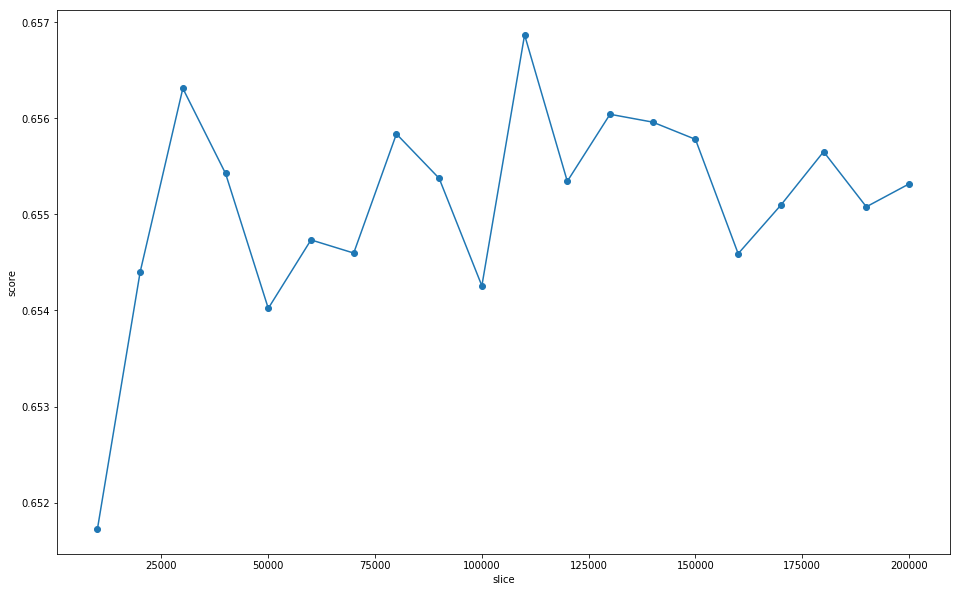

In [58]:
def try_slice(plot=True, steps=10):

    slices, scores, classifiers = [], [], {}
    best_slice, best_score = None, None

    for slc in range(10000, 200001, 10000):
        sc_train, sc_test, clf, score = shuffle(x1, y_train, slc=slc, steps=steps, plot=False)
        slices.append(slc)
        scores.append(score)
        if best_slice is None or best_scores < score:
            best_slice, best_score = slc, score
        classifiers[slc] = clf
        print "slice", slc, "\t", score

    if plot:
        plt.figure(figsize=(16, 10))
        plt.xlabel("slice")
        plt.ylabel("score")
        plt.plot(slices, scores, '-o')
        plt.show()
    
    return classifiers[best_slice]

best_clf = try_slice()

__Some interpretation__

Tests showed that the slice does not really impact the score. However, the more data are processed the more stabilized reults get. One then may select let's say `50000` as a default slice and then perform much more tests to try to, by chance, find a good one.

In [125]:
sc_train, sc_test, clf, score = shuffle(x1, y_train, slc=130000, steps=10, plot=False)

In [126]:
score

0.6559166396254827

In [128]:
output(clf, x1, x2)

shape: (800468, 2)
generated output at ypred_2018_04_14_16_48_04.txt	(20.09s)


In [20]:
from sklearn.model_selection import cross_val_score

depths, scores = [], []

for max_depth in range(10, 201, 10):
    clf = RandomForestClassifier(max_depth=max_depth)
    score = cross_val_score(clf, x1.loc[:50000], y_train.loc[:50000, "ReturnQuantityBin"], cv=5).mean()
    depths.append(max_depth)
    scores.append(score)
    print 'max_depth:', max_depth, '\tscore:', score

max_depth: 10 	score: 0.7904241907464419
max_depth: 20 	score: 0.7837043827060438
max_depth: 30 	score: 0.7641646465896466
max_depth: 40 	score: 0.7519450905184509
max_depth: 50 	score: 0.7520049165158491
max_depth: 60 	score: 0.7518849505168496
max_depth: 70 	score: 0.7509051305164514
max_depth: 80 	score: 0.7523450245226503
max_depth: 90 	score: 0.7530050525222506
max_depth: 100 	score: 0.7518051165306512
max_depth: 110 	score: 0.7562650105484501
max_depth: 120 	score: 0.7516650545148506
max_depth: 130 	score: 0.7531449625248496
max_depth: 140 	score: 0.7515450645214508
max_depth: 150 	score: 0.7527851165222512
max_depth: 160 	score: 0.7530050285102503
max_depth: 170 	score: 0.7541649545348494
max_depth: 180 	score: 0.7515251585076517
max_depth: 190 	score: 0.7510651385024513
max_depth: 200 	score: 0.7521451345096513


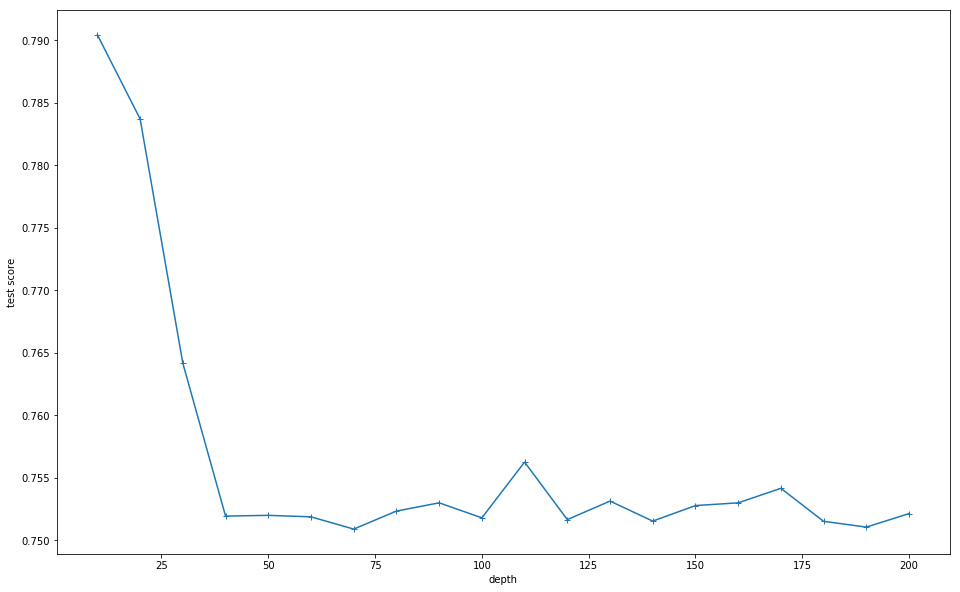

In [21]:
plt.figure(figsize=(16, 10))
plt.xlabel("depth")
plt.ylabel("test score")
plt.plot(depths, scores, '-+')
plt.show()

In [22]:
from sklearn.model_selection import cross_val_score

depths, scores = [], []

for max_depth in range(1, 20):
    clf = RandomForestClassifier(max_depth=max_depth)
    score = cross_val_score(clf, x1.loc[:50000], y_train.loc[:50000, "ReturnQuantityBin"], cv=5).mean()
    depths.append(max_depth)
    scores.append(score)
    print 'max_depth:', max_depth, '\tscore:', score

max_depth: 1 	score: 0.7912241767474417
max_depth: 2 	score: 0.7912241767474417
max_depth: 3 	score: 0.7912241767474417
max_depth: 4 	score: 0.7912241767474417
max_depth: 5 	score: 0.7906641747476417
max_depth: 6 	score: 0.7911041787476417
max_depth: 7 	score: 0.7913441707488417
max_depth: 8 	score: 0.7910241787496418
max_depth: 9 	score: 0.790704192744642
max_depth: 10 	score: 0.7899842167458422
max_depth: 11 	score: 0.7900041887442419
max_depth: 12 	score: 0.7899841767450418
max_depth: 13 	score: 0.7900842087410421
max_depth: 14 	score: 0.7891041727390418
max_depth: 15 	score: 0.7884041587376416
max_depth: 16 	score: 0.7885242147336422
max_depth: 17 	score: 0.7860241727158417
max_depth: 18 	score: 0.7870443087298431
max_depth: 19 	score: 0.7839042567114426


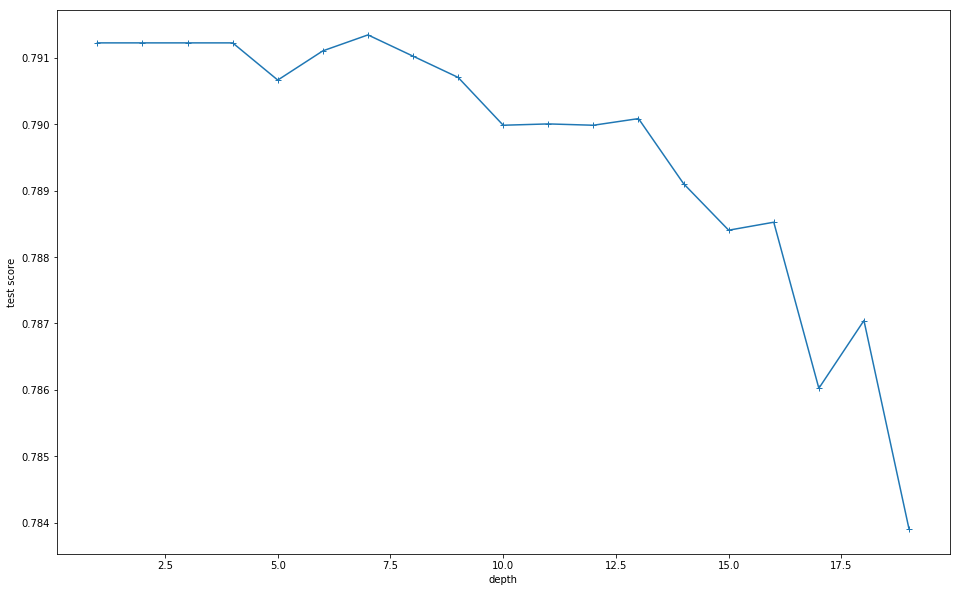

In [23]:
plt.figure(figsize=(16, 10))
plt.xlabel("depth")
plt.ylabel("test score")
plt.plot(depths, scores, '-+')
plt.show()

In [37]:
def shuffle(x, y, clf_fun, steps=10, slc=50000, plot=True):
    scores_train, scores_test = [], []
    best_clf, best_score = None, None
    
    z = x.copy(deep=True)
    z["ReturnQuantityBin"] = y.ReturnQuantityBin
    
    for k in range(steps):
        u = z.sample(frac=1)
        v = u.loc[:, ["ReturnQuantityBin"]]
        u = u.drop(["ReturnQuantityBin"], axis=1)
        
        clf = clf_fun()
        clf.fit(u.iloc[:slc], v.ReturnQuantityBin[:slc])
        
        predict_train = clf.predict_proba(u.iloc[:slc])
        score_train = roc_auc_score(v.ReturnQuantityBin[:slc], predict_train[:, 1])
    
        predict_test = clf.predict_proba(u.iloc[slc:2 * slc])
        score_test = roc_auc_score(v.ReturnQuantityBin[slc:2 * slc], predict_test[:, 1])
        
        if best_clf is None or score_test > best_score:
            best_clf, best_score = clf, score_test
        
        if plot:
            print "test", k, "\ttrain:", score_train, "\ttest:", score_test
        
        scores_train.append(score_train)
        scores_test.append(score_test)
    
    if plot:
        plt.figure(figsize=(16, 10))
        plt.xlabel("train score")
        plt.ylabel("test score")
        plt.plot(scores_train, scores_test, '+')
        plt.show()
    
    return scores_train, scores_test, best_clf, best_score

In [46]:
for depth in range(1, 20):
    scores_train, scores_test, best_clf, best_score = shuffle(x1, y_train, lambda : RandomForestClassifier(max_depth=depth), steps=2, plot=False)
    print "depth:", depth, "\tscore:", best_score

depth: 1 	score: 0.5937632784642071
depth: 2 	score: 0.6231636530295178
depth: 3 	score: 0.627035703816593
depth: 4 	score: 0.6314567170789827
depth: 5 	score: 0.6443925233633563
depth: 6 	score: 0.6426199291663743
depth: 7 	score: 0.6438383609287358
depth: 8 	score: 0.6430986251287547
depth: 9 	score: 0.6492529326414576
depth: 10 	score: 0.6372310034589369
depth: 11 	score: 0.6452063008906477
depth: 12 	score: 0.6478928667762367
depth: 13 	score: 0.642255930747902
depth: 14 	score: 0.6432875684259614
depth: 15 	score: 0.640213500046978
depth: 16 	score: 0.6377049123388554
depth: 17 	score: 0.6273680374389201
depth: 18 	score: 0.624518439665826
depth: 19 	score: 0.6273739973706132


test 0 	train: 0.6891914154415001 	test: 0.6441228908768595
test 1 	train: 0.6822866591271202 	test: 0.6434748236750842
test 2 	train: 0.6892266246492293 	test: 0.6461208125635293
test 3 	train: 0.6851726420772801 	test: 0.6423472983584665
test 4 	train: 0.6853834021282402 	test: 0.6441773067275722
test 5 	train: 0.6874982997094032 	test: 0.6436040962796734
test 6 	train: 0.6797917681026424 	test: 0.6377490688409847
test 7 	train: 0.682691192836395 	test: 0.6411208007789491
test 8 	train: 0.6786094188045863 	test: 0.6374402084406015
test 9 	train: 0.6780966707981733 	test: 0.6410661763325501


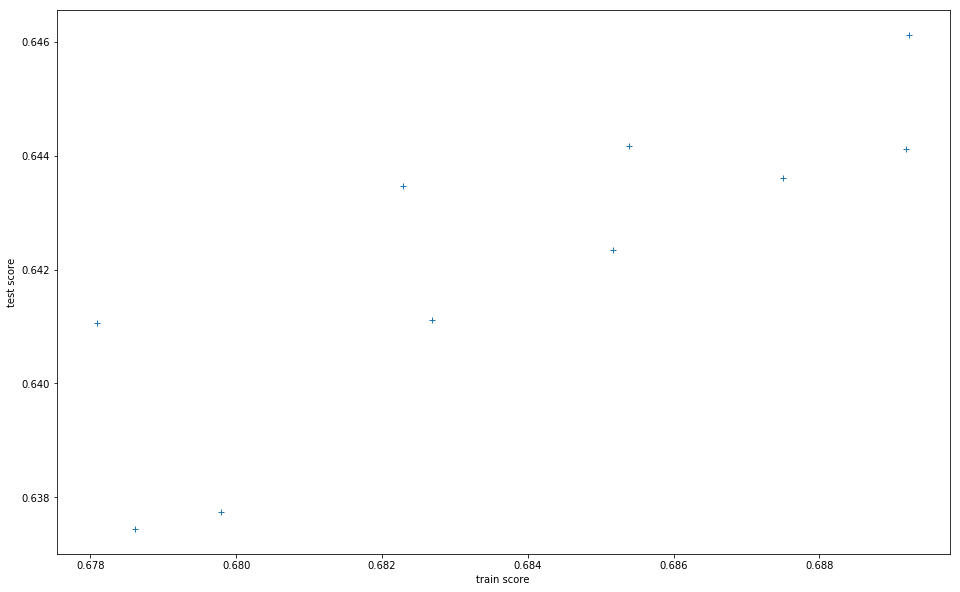

([0.6891914154415001,
  0.6822866591271202,
  0.6892266246492293,
  0.6851726420772801,
  0.6853834021282402,
  0.6874982997094032,
  0.6797917681026424,
  0.682691192836395,
  0.6786094188045863,
  0.6780966707981733],
 [0.6441228908768595,
  0.6434748236750842,
  0.6461208125635293,
  0.6423472983584665,
  0.6441773067275722,
  0.6436040962796734,
  0.6377490688409847,
  0.6411208007789491,
  0.6374402084406015,
  0.6410661763325501],
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=9, max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
             verbose=0, warm_start=False),
 0.6461208125635293)

In [47]:
shuffle(x1, y_train, lambda : RandomForestClassifier(max_depth=9), steps=10)

In [169]:
def prune(x1, x2, y, threshold=1, slc=100000, max_depth=9, do_score=True, do_print=True, do_plot=True):
    # building the random forest classifier on a suffled training set
    slc = 100000
    z = x1.copy(deep=True)
    z["ReturnQuantityBin"] = y_train.ReturnQuantityBin
    u = z.sample(frac=1)
    v = u.loc[:, ["ReturnQuantityBin"]]
    u = u.drop(["ReturnQuantityBin"], axis=1)
    forest = RandomForestClassifier(max_depth=9)
    forest.fit(u.iloc[:slc], v.ReturnQuantityBin[:slc])
    
    # computing test scores
    if do_score:
        predict_test = forest.predict_proba(u.iloc[slc:2 * slc])
        score_test = roc_auc_score(v.ReturnQuantityBin[slc:2 * slc], predict_test[:, 1])
        print "test score:", score_test
    
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    # print the feature ranking
    if do_print:
        print "Feature ranking:"
        for f in range(u.shape[1]):
            print("%d. %s (%f)" % (f + 1, u.columns[indices[f]], importances[indices[f]]))
    
    # plot the feature ranking
    if do_plot:
        plt.figure(figsize=(16, 10))
        plt.title("Feature importances")
        plt.bar(range(u.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
        plt.xticks(range(u.shape[1]), indices)
        plt.xlim([-1, u.shape[1]])
        plt.show()
        
    # pruning x1 and x2
    whitelist = [u.columns[indices[f]] for f in range(min(threshold, len(u.columns)))]
    x3 = x1.drop([col for col in x1.columns if col not in whitelist], axis=1)
    x4 = x2.drop([col for col in x2.columns if col not in whitelist], axis=1)
    return x3, x4

def find_threshold(x1, x2, y, slc=100000, max_depth=9):
    # building the random forest classifier on a suffled training set
    slc = 100000
    z = x1.copy(deep=True)
    z["ReturnQuantityBin"] = y_train.ReturnQuantityBin
    u = z.sample(frac=1)
    v = u.loc[:, ["ReturnQuantityBin"]]
    u = u.drop(["ReturnQuantityBin"], axis=1)
    forest = RandomForestClassifier(max_depth=9)
    forest.fit(u.iloc[:slc], v.ReturnQuantityBin[:slc])
    
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    best_t, best_score = None, None
    for threshold in range(1, 101):
        whitelist = [u.columns[indices[f]] for f in range(min(threshold, len(u.columns)))]
        x3 = x1.drop([col for col in x1.columns if col not in whitelist], axis=1)
        x4 = x2.drop([col for col in x2.columns if col not in whitelist], axis=1)
        sc_train, sc_test, clf, score = shuffle(x3, y_train, slc=100000, steps=2, plot=False)
        if best_t is None or best_score < score:
            best_t, best_score = threshold, score
        print "threshold:", threshold, "\tshape:", x3.shape, "\tscore:", score
    
    return best_t, best_score

In [170]:
find_threshold(x1, x2, y_train)

threshold: 1 	shape: (1067290, 1) 	score: 0.574356605386431
threshold: 2 	shape: (1067290, 2) 	score: 0.5856617291218396
threshold: 3 	shape: (1067290, 3) 	score: 0.6154359104170999
threshold: 4 	shape: (1067290, 4) 	score: 0.6337566424354024
threshold: 5 	shape: (1067290, 5) 	score: 0.6351526668057986
threshold: 6 	shape: (1067290, 6) 	score: 0.6335189564429284
threshold: 7 	shape: (1067290, 7) 	score: 0.6355780083385949
threshold: 8 	shape: (1067290, 8) 	score: 0.636939926419611
threshold: 9 	shape: (1067290, 9) 	score: 0.6358006403113113
threshold: 10 	shape: (1067290, 10) 	score: 0.6405117479036697
threshold: 11 	shape: (1067290, 11) 	score: 0.6415424440098114
threshold: 12 	shape: (1067290, 12) 	score: 0.6412234090026194
threshold: 13 	shape: (1067290, 13) 	score: 0.6443138341425757
threshold: 14 	shape: (1067290, 14) 	score: 0.6420528173621186
threshold: 15 	shape: (1067290, 15) 	score: 0.6456081277227377
threshold: 16 	shape: (1067290, 16) 	score: 0.6447569832212464
threshold: 1

(68, 0.657293670948485)

test 0 	train: 0.6459979624375067 	test: 0.6465171859759469
test 1 	train: 0.6469237937231148 	test: 0.6502324199041669
test 2 	train: 0.6456313523173876 	test: 0.6484931902863063
test 3 	train: 0.6485272949490786 	test: 0.646645495718916
test 4 	train: 0.6466164986683063 	test: 0.6444993330427363
test 5 	train: 0.6475535061472868 	test: 0.6456752369675604
test 6 	train: 0.6459622359306412 	test: 0.6501444747268446
test 7 	train: 0.6469440086651036 	test: 0.6460775489289443
test 8 	train: 0.648579527639573 	test: 0.6451953263351881
test 9 	train: 0.6469833710062032 	test: 0.6441433060618417


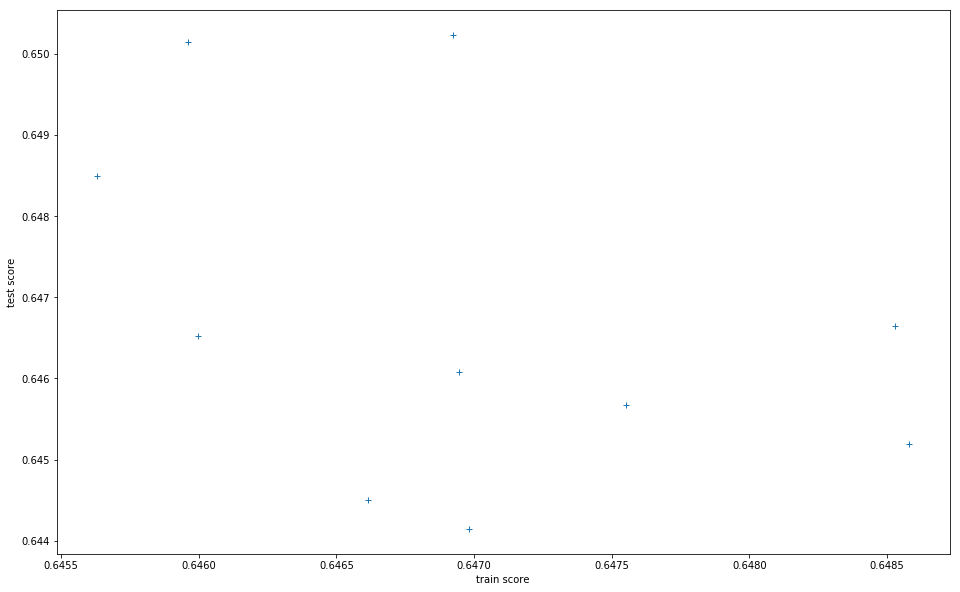

In [158]:
x3, x4 = prune(x1, x2, y_train, threshold=68)